In [83]:
using Random
using Statistics
using Plots
using Distributions
using DataFrames
using GLM
using StatsBase
using CSV
using LinearAlgebra
using Optim

# n変量VAR(p)モデル

誘導型のVARモデル
$$Y_t = \begin{pmatrix} y_{1t} \\ \vdots \\ y_{nt} \end{pmatrix}= V + \sum_{i = 1}^p \Phi_i Y_{t-i} + E_t $$

ただし $$V = \begin{pmatrix} \nu_1 \\ \vdots \\ \nu_n \end{pmatrix}, \: \Phi_i = \begin{bmatrix} \phi_{11i} & \dots & \phi_{1ni} \\ \vdots & \ddots & \vdots \\ \phi_{n1i} & \dots & \phi_{nni} \end{bmatrix}, \: E_t = \begin{pmatrix} \varepsilon_{1t} \\ \vdots \\ \varepsilon_{nt} \end{pmatrix}, \quad \mathbb{E}(E_t) = O, \: \Sigma_{E_t} = \begin{bmatrix} \sigma_1^2 & \sigma_{12} & \dots & \sigma_{1n} \\ \sigma_{12} & \sigma_2^2 & \dots & \sigma_{2n}\\ \vdots & \vdots  &\ddots &\vdots \\ \sigma_{1n} & \sigma_{2n} & \dots & \sigma_{n}^2  \end{bmatrix} \quad \text{とする} $$

構造ショック
$$E_t = C e_t = \begin{bmatrix} c_{11} &\dots & c_{1n} \\ \vdots &\ddots &\vdots \\ c_{n1} & \dots & c_{nn} \end{bmatrix} \begin{pmatrix} e_{1t} \\ \vdots \\ e_{nt} \end{pmatrix}$$
ただし $$\mathbb{E}(e_t) = O, \: \Sigma_{e_t} = I \quad \text{とする}$$

## 1. 理想的なデータセットを生成して分析(二変量VAR(1)モデル)

### データセット生成

In [135]:
#設定

n = 2 #変量
p = 1 #ラグ次数
T = 1500

Nu = [0; 0]
C = [0 2; 1 1.5] #c_11 = 0の短期制約を仮定しておく

Phi1 = [1.2 -.7; .5 -0.6] #左上からphi_11, phi_12, phi_21, phi_22
y0 = [.0; .0]


#誤差項の生成
Random.seed!(1234)
e = randn(T, n)

1500×2 Matrix{Float64}:
  0.970656    0.677332
 -0.979218   -1.358
  0.901861    0.0355765
 -0.0328031   0.306842
 -0.600792    0.238358
 -1.44518     0.781377
  2.70742    -0.84419
  1.52445     0.536188
  0.759804    2.65314
 -0.881437    0.976301
  0.705993   -0.674082
  1.09156     0.91236
  0.871498    0.452563
  ⋮          
  0.974094    0.249555
 -1.03584     0.10155
 -0.718772    1.22854
 -0.846241    0.628459
  0.609231   -0.567771
  0.751628   -0.149759
 -0.425541   -0.146104
  2.07629     0.316819
 -0.995022   -1.26449
  1.30908     1.61804
 -0.8816      0.921972
  1.73721     0.429639

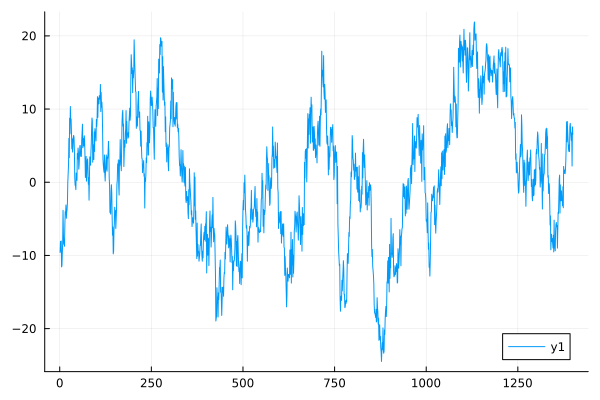

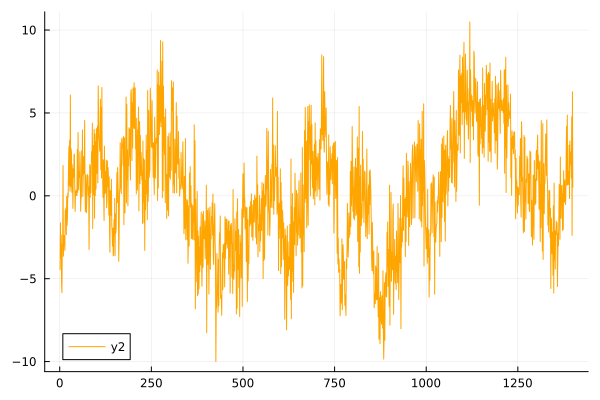

In [136]:
#データセットの生成
y = zeros(T+p, n)
y[1:p, :] = y0
for t in 1:T
    temp = [0; 0]
    for i in 1:p
        #i = 1のみより
        temp += Phi1 * y[t+i-p:t+i-1,:]'
    end
    err = C * e[t,:]
    y[t+1,:] = Nu + temp + err
end
y = y[p+100:T,:]

display(plot(y[:,1], label = "y1"))
display(plot(y[:,2], label = "y2", linecolor = "orange"))

### パラメータ推定

In [137]:
function LagorderVAR(y, p_max)
    T = size(y, 1)
    n = size(y, 2)
    Mat_IC = zeros(p_max, 2)
    
    for p in 1:p_max #pの探索領域最大値
        y_dep = y[1+p:T,:]
        y_exp = ones(T-p, n*p+1)
        for j in 1:p #各ラグ次数ｊに対して
            for k in 1:n #各ykに対して
                y_exp[:,n*(j-1)+k+1] = y[j : T-p+j-1, k]
            end
        end
        
        temp_err = zeros(T-p, n)
        Mat_Sigma = zeros(n,n) #分散共分散行列
        for k in 1:n 
            model_temp = lm(y_exp, y_dep[:,k])
            temp_err[:,k] = residuals(model_temp)
            Mat_Sigma[k,k] = deviance(model_temp) #分散
        end
        
        
        for i in 1:n
            for j in i+1:n
                Mat_Sigma[i,j] = cov(temp_err[:,i], temp_err[:,j]) #共分散
                Mat_Sigma[j,i] = Mat_Sigma[i,j]
            end
        end
        detS = det(Mat_Sigma)
        Mat_IC[p,:] = [log(detS)+(p*n^2+n)*2/T log(detS)+(p*n^2+n)*log(T)/T]
        
    end
    Mat_IC = DataFrame(Mat_IC, [:AIC, :BIC])

    println(Mat_IC) #情報基準を表示

    #各基準ごとに最小にするラグ次数を返す
    min_v = minimum.(eachcol(Mat_IC[!, :]))'

    p_sel = [findall(x -> x == min_v[1], Mat_IC[:,1])[1] findall(x -> x == min_v[2], Mat_IC[:,2])[1]]
    
    return p_sel
end

LagorderVAR (generic function with 1 method)

In [138]:
LagorderVAR(y, 8)

8×2 DataFrame
 Row │ AIC      BIC     
     │ Float64  Float64 
─────┼──────────────────
   1 │ 17.1094  17.1318
   2 │ 17.1113  17.1488
   3 │ 17.1114  17.1639
   4 │ 17.1132  17.1806
   5 │ 17.1141  17.1965
   6 │ 17.1139  17.2113
   7 │ 17.1172  17.2295
   8 │ 17.1163  17.2437


1×2 Matrix{Int64}:
 1  1

In [139]:
p_sel = 1

1

（誘導型）誤差項と構造ショックの関係 
$$ \Sigma_{E_t} = E_t \: E_t' = C e_t \: e_t' C' = C I C' = C C' $$

$\Sigma_{E_t}$は対称行列であるが、$CC'$は一般の製正方行列であるため、個だけ、Cを一致推定するために必要な$\Sigma_{E_t}$の要素（情報）が$\:n(n-1) \over 2 \:$個だけたりない。そのため、（一つの方法として）短期制約を$\:n(n-1) \over 2 \:$個のパラメータに対して課す

$n = 2, p = 1$のとき、$c_{11} = 0$を課すと、
$$\begin{bmatrix} \sigma_1^2 & \sigma_{12} \\ \sigma_{12} & \sigma_{2}^2 \end{bmatrix} = \begin{bmatrix} c_{11}^2 + c_{12}^2 & c_{11} c_{21} + c_{12} c_{22} \\ c_{11} c_{21} + c_{12}c_{22} & c_{21}^2 c_{22}^2 \end{bmatrix} = \begin{bmatrix} c_{12}^2 & c_{12} c_{22} \\ c_{12}c_{22} & c_{21}^2 + c_{22}^2 \end{bmatrix}$$
従って
$$\left\{ \begin{align*} c_{12} &= \sigma_1 \\ c_{21} &= \sqrt{\sigma_2^2 - {\sigma_{12}^2 \over \sigma_1^2} }\\ c_{22} &= {\sigma_{12} \over \sigma_1} \end{align*} \right.$$

In [140]:
function Struc_Coef_Est(Mat, C)
    n = size(Mat, 1)
    for i in 1:n-1
        for j in 1:n-1
            C[i,j] = 0
        end
    end
    return norm(Mat - C*C')
end

Struc_Coef_Est (generic function with 1 method)

In [142]:
#phiのOLS推定とCの計算
function VAR_OLS(y, p_sel)
    T = size(y,1)
    n = size(y,2)

    y_dep = y[1+p_sel:T,:]
    y_exp = ones(T-p_sel, n*p_sel+1)
    for j in 1:p_sel #各ラグ次数ｊに対して
        for k in 1:n #各ykに対して
            y_exp[:,n*(j-1)+k+1] = y[j : T-p_sel+j-1, k]
        end
    end
    
    temp_err = zeros(T-p_sel, n)
    Mat_Sigma = zeros(n,n) #分散共分散行列
    phis = zeros(n, n*p_sel)
    for k in 1:n 
        model = lm(y_exp, y_dep[:,k])
        print("y_$k に対する回帰 \n", model,"\n")
        phis[k,:] = coef(model)[2:n+1]
        temp_err[:,k] = residuals(model)
        Mat_Sigma[k,k] = deviance(model)/(T-p-1) #不偏分散
    end
    
    for i in 1:n
        for j in i+1:n
            Mat_Sigma[i,j] = cov(temp_err[:,i], temp_err[:,j]) #不偏共分散
            Mat_Sigma[j,i] = Mat_Sigma[i,j]
        end
    end
    
    Struc_coef = optimize(C -> Struc_Coef_Est(Mat_Sigma, C), ones(n,n))
    C_est = Optim.minimizer(Struc_coef)
    print(Struc_coef)

    return phis, C_est
end
    
 

VAR_OLS (generic function with 1 method)

In [143]:
phi ,C_est = VAR_OLS(y, p_sel)

y_1 に対する回帰 
LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}:

Coefficients:
───────────────────────────────────────────────────────────────────
          Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────
x1  -0.00128387   0.054865    -0.02    0.9813  -0.108911   0.106343
x2   1.23754      0.0142404   86.90    <1e-99   1.2096     1.26547
x3  -0.789494     0.0379882  -20.78    <1e-83  -0.864015  -0.714974
───────────────────────────────────────────────────────────────────

y_2 に対する回帰 
LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}:

Coefficients:
──────────────────────────────────────────────────────────────────
         Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────
x1  -0.053901

([1.2375380559698315 -0.7894944659208017; 0.5274187512437077 -0.6557853725371463], [0.0 2.0361099954564885; 1.0164381899852808 1.504715683178366])

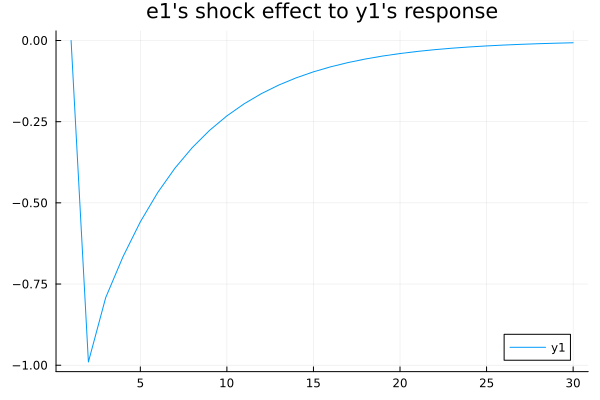

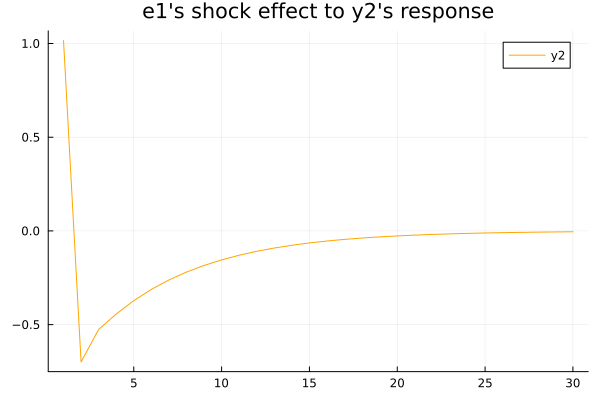

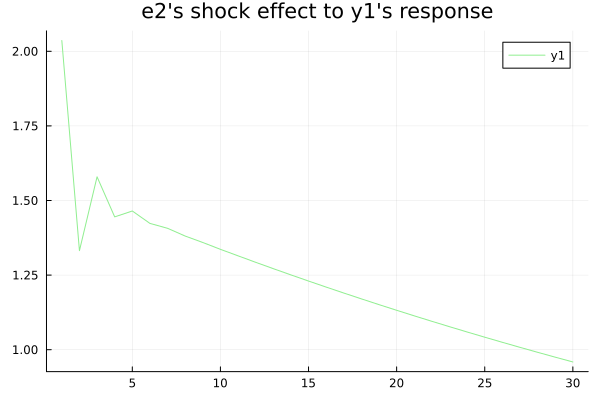

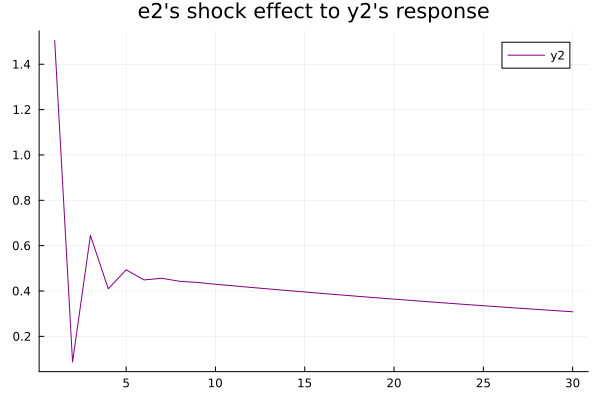

In [145]:
#2変量VAR(1)のインパルス応答関数描画

plotT = 30 #描画最大期

#e1のショック
Resp1 = zeros(plotT+p_sel, 2)
Resp1[p_sel, :] = C_est * [1.0; .0]
for t in 1:plotT
    Resp1[t+p_sel,:] = phi * Resp1[t:t+p_sel-1,:]'
end
Resp1 = Resp[p_sel:plotT, :]

#e2のショック
Resp2 = zeros(plotT+p_sel, 2)
Resp2[p_sel, :] = C_est * [.0; 1.0]
for t in 1:plotT
    Resp2[t+p_sel,:] = phi * Resp2[t:t+p_sel-1,:]'
end
Resp2 = Resp2[p_sel:plotT, :]

display(plot(Resp1[:,1], title = "e1's shock effect to y1's response", label = "y1"))
display(plot(Resp1[:,2], title = "e1's shock effect to y2's response", label = "y2", linecolor = "orange"))
display(plot(Resp2[:,1], title = "e2's shock effect to y1's response", label = "y1", linecolor = "lightgreen"))
display(plot(Resp2[:,2], title = "e2's shock effect to y2's response", label = "y2", linecolor = "purple"))